
# Bootstrapping in Python

### Justin Sulik

### [https://github.com/justinsulik/bootstrapping](github.com/justinsulik/bootstrapping)

### [justinsulik.com](justinsulik.com)

### @justinsulik


# Bootstrapping

- To pull yourself up by your own bootstraps
- Sounds like it's getting something from nothing
- But it's a robust, easy, modern, elegant approach to stats

<img src="munchausen.jpg" style='float: right; height: 400px;'>

# Two slogans

- "Simulate and see!"
- "Make the computer do all the work!"

# Outline

## Workshop 1
- Calculation vs simulation
- Bootstrap resampling
- Means and confidence intervals
- Difference in means
- DIY

## Workshop 2
- Regression parameters
- Other statistics
- Why care about confidence intervals? "The new statistics"
- Parametric vs. non-parametric bootstrap
- Bootstrap vs. random permutation test
- DIY

# Today's learning objectives

To understand:

- the difference between simulating and calculating

- how to do resampling with replacement

- why bootstrapping is robust and general

- how to bootstrap a confidence interval around a sample mean

- how to bootstrap a CI for the difference between two means

To think about:

- what CIs are

- why bootstrapping works

# Calculation vs Simulation

- Bootstrapping is one example of a broad approach to stats: resampling
    - Others include permutation tests, Monte Carlo methods, cross-validation, jackknife...
- These approaches involve simulating rather than calculating
- Think of this as *statistics without formulas*

# Calculation vs Simulation

- You toss a coin 30 times 
- There are 22 heads
- That seems higher than expected
- How likely is it that a random coin toss results in at least 22 heads?

# Calculation

You need to know this formula:

$\binom{N}{N_H}(\frac{1}{2})^{N_H}(\frac{1}{2})^{N_T}$

N = tosses, $N_H$ = number of heads, $N_T$ = number of tails

In [3]:
import numpy as np, random, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from scipy import misc
%matplotlib inline

p = 0
for i in range(22, 31):
    comb = misc.comb(30,i)
    p+=comb*0.5**i*0.5**(30-i)
    
round(float(p), 4)

0.0081

# Simulating

**(Not bootstrapping, yet)**

Instead of knowing/remembering/looking up the formula, just simulate and see!

Simulate tossing a fair dice lots of times (say, 10 000)

See on how many of those simulations there were more than 22 heads

In [399]:

R = 10000
M = 0
for _ in range(R):
    tosses = [random.randrange(0,2) for x in range(30)]
    if sum(tosses)>=22:
        M+=1

p = M/R
p

0.0084

# Pros and Cons

Calculating
- Exact
- Same results every time
- Burden is on your knowledge
    
Simulating
- Inexact
- Results vary
- Burden is on your computer

# You try it

What if the question changed:
- If you had two coins?
- If you had dice?

Easier to recall/find/derive the formula? Or update your simulation?

Simulate/calculate the probability that *at least* 1 coin will show 20 heads if you have 2 coins and toss them 30 times each

Simulate/calculate the probability that 2 dice will add to 5 or more

In [81]:
R = 10000
M = 0
for _ in range(R):
    coin1 = [random.randrange(0,2) for x in range(30)] 
    coin2 = [random.randrange(0,2) for x in range(30)]
    if sum(coin1)>=20 or sum(coin2)>=20:
        M+=1
p = M/R
p

0.0968

In [82]:
R = 10000
M = 0
for _ in range(R):
    dice1 = random.randrange(1,7)
    dice2 = random.randrange(1,7)
    if dice1 + dice2 >= 5:
        M+=1
        
p = M/R
p

0.8326

# Are we all on board?

Do you get the difference between simulating and calculating?

Do you feel comfortable with this approach?

Ok, let's move on to bootstrapping

# What stats do we report when we do an experiment?

In addition to a sample statistic (mean, proportion, r, $\beta$) we need to give some measure of accuracy (variability, uncertainty or how the data are distributed)

- sd
- se
- CI

M=23.3, 95% CI [17.2, 43.7]

To do this, we can
- Use formulae (calculate), or
- Bootstrap (simulate)

# The old-fashioned way

Calculate 95% CI

estimator $\pm$ (reliability coefficient) * (standard error)

$\overline{x}\pm 1.96*SE$

= $\overline{x}\pm 1.96*\frac{sd}{\sqrt{n}}$

Do you know if that's a z- or a t-score? When to use one rather than the other?

Do you know what the assumptions have to be met for this formula to hold?

In [66]:

data1 = np.random.normal(10, 4, 50)
mean = np.mean(data1)
sd = np.std(data1)
interval = 1.96*(sd/len(data1)**0.5)
print("M={} 95% CI [{}, {}]".format(round(mean,2), round(mean-interval, 2), round(mean+interval,2)))

data2 = np.random.normal(10, 4, 20)
mean = np.mean(data2)
sd = np.std(data2)
interval = 2.093*sd/len(data2)**0.5 #Use 2.093 because this is a t-statistic because N < 30
print("M={} 95% CI [{}, {}]".format(round(mean,2), round(mean-interval, 2), round(mean+interval,2)))


M=10.4 95% CI [9.28, 11.53]
M=10.7 95% CI [8.87, 12.53]


# Bootstrapping

Bootstrapping uses resampling **with replacement** to interrogate your data ("empirical sample")

For each bootstrap sample, draw N items from your data, with replacement

data = [1, 2, 3, 4, 5]

sample$^*_1$ = [2, 4, 5, 1, 2]

sample$^*_2$ = [4, 3, 4, 2, 5]

...

([see animation here](https://www.stat.auckland.ac.nz/~wild/BootAnim/movies/bootstrap1.mp4))

# Bootstrapping

Each time, just take the statistic you're interested in

data = [1, 2, 3, 4, 5]          mean = 3

sample$^*_1$ = [2, 4, 5, 1, 2]  mean = 2.79

sample$^*_2$ = [4, 3, 4, 2, 5]  mean = 3.6

...

# Bootstrapping

Repeat lots of times (e.g. 10 000)

Just treat the set of bootstrap samples as informative about the distribution of the statistic you're interested in

(I.e., just make inferences from the resampled data)

First, let's check that it works

Then, we'll discuss *why* it works

In [354]:
bootSamples = []
for _ in range(10000):
    bootstrapSample = np.random.choice(data1, len(data1))
    bootstrapMean = np.mean(bootstrapSample)
    bootSamples.append(bootstrapMean)

mean = np.mean(data1)
deltaStar = [x-mean for x in bootSamples]
lower = mean+np.percentile(deltaStar, 2.5) #We'll learn to do something more sophisticated than this later!
upper = mean+np.percentile(deltaStar, 97.5)
print("M={} 95% CI [{}, {}]".format(round(mean, 2), round(lower,2), round(upper, 2)))

M=10.4 95% CI [9.27, 11.53]


In [377]:
bootSamples = []
for _ in range(10000):
    bootstrapSample = np.random.choice(data2, len(data2))
    bootstrapMean = np.mean(bootstrapSample)
    bootSamples.append(bootstrapMean)

mean = np.mean(data2)
deltaStar = [x-mean for x in bootSamples]
lower = mean+np.percentile(deltaStar, 2.5) #We'll learn to do something more sophisticated than this later!
upper = mean+np.percentile(deltaStar, 97.5)
print("M={} 95% CI [{}, {}]".format(round(mean, 2), round(lower,2), round(upper, 2)))

M=10.7 95% CI [9.03, 12.42]


# Ok, it works. Why?



# Practical
For the formula, we treat the sample as representative

So for the bootstrap we treat it as representative

The sample is all we have. Let's use it!

The claim is not that we're learning something new about **the population**

We're learning something about **the sampling distribution**

# A bit more formal

empirical sample $\leftrightarrow$ population F ~ resampled data F\* $\leftrightarrow$ empirical sample
 
For statistic $u$ calculated from the empirical sample, and $u^*$ from F*,

IF the sample is representative of population 
 
THEN the variation in $u$ is well approximated by the variation in $u^*$

# A few more points

Since we resample with replacement, F\* won't have same properties as the original

We're **not** learning anything more about the point estimate, or about the population. 

We're learning more about the **distribution** of the statistic

We used percentiles to derive confidence intervals directly from F\* above. We'll learn fancier ways to derive CIs next week. 

# You try it

Generate some random normal samples OR find some of your own data

Use the formula and bootstrapping to see how closely CIs for the means

If they're different, why do you think that is?

Convince yourself it works before we look in more detail at the logic behind the bootstrap

# Let's check the bigger picture

#### Tricky to get your head around it? Best thing to do is simulate some more!

Assume a large population F (say 5 million people)

An experimenter might just take one sample from F (time! money!)

Let's take a bunch of samples from F (like several experimenters replicating an experiment)

See what we're learning about: point estimates (No!) vs confidence (Yes!)

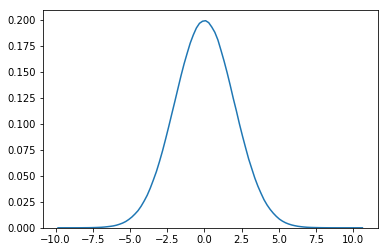

In [169]:

population = np.random.normal(0,2,5000000)

sns.kdeplot(population)

sample1    Axes(0.125,0.125;0.775x0.755)
sample2    Axes(0.125,0.125;0.775x0.755)
sample3    Axes(0.125,0.125;0.775x0.755)
sample4    Axes(0.125,0.125;0.775x0.755)
dtype: object

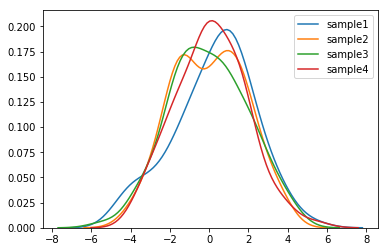

In [159]:
import pandas as pd

# Imagine 4 independent experimenters sampled from the same population

sample1 = np.random.choice(population, 100)
sample2 = np.random.choice(population, 100)
sample3 = np.random.choice(population, 100)
sample4 = np.random.choice(population, 100)

df = pd.DataFrame.from_dict({'sample1': sample1, 'sample2': sample2, 'sample3': sample3, 'sample4': sample4})

df.apply(sns.kdeplot)

sample1    Axes(0.125,0.125;0.775x0.755)
sample2    Axes(0.125,0.125;0.775x0.755)
sample3    Axes(0.125,0.125;0.775x0.755)
sample4    Axes(0.125,0.125;0.775x0.755)
dtype: object

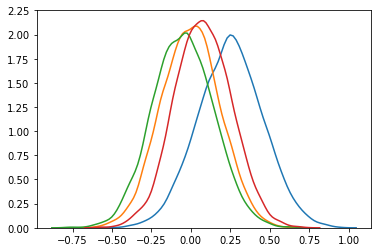

In [170]:

# Bootstrap each experimenter's data/empirical sample

def myBoot(column):
    bootMeans = [np.mean(np.random.choice(column, len(column))) for x in range(10000)]
    return bootMeans
    
bootDf = df.apply(myBoot)

bootDf.apply(sns.kdeplot)

In [171]:
# Compare empirical means with bootstrapped means

print(df.apply(np.mean))
print(bootDf.apply(np.mean))

# The same! So we're not learning anything about the point estimates or the population mean!

sample1    0.247946
sample2   -0.005468
sample3   -0.048225
sample4    0.077600
dtype: float64
sample1    0.250180
sample2   -0.002179
sample3   -0.048552
sample4    0.077337
dtype: float64


In [356]:
def getCIs(column):
    CI = np.percentile(column,[2.5,97.5])
    return(CI)

bootDf.apply(getCIs)

#So the bootstrapped CIs *usually* contain the population mean

sample1    [-0.158141335163, 0.656312781122]
sample2    [-0.364146685813, 0.356611058886]
sample3    [-0.418268047996, 0.333888423411]
sample4    [-0.274893451042, 0.433482606802]
dtype: object

In [357]:
#Let's quantify *usually*

# Return True if population mean (i.e. 0) is in the bootstrapped CI
def popMeanInRange(column):
    CI = np.percentile(column,[2.5,97.5])
    return True if CI[0] <= 0 <= CI[1] else False

bootDf.apply(popMeanInRange)

sample1    True
sample2    True
sample3    True
sample4    True
dtype: bool

In [164]:
# What if we had 100 samples from the population, instead of 4?

df100 = pd.DataFrame.from_dict({x: np.random.choice(population, 100) for x in range(100)})
bootDf = df100.apply(myBoot)
bootDf.apply(popMeanInRange).sum()

94

# What have we learned by getting bootstrapped CIs?

We don't have access to the whole population (too big/expensive/time consuming)

We have an empirical sample

If we've done our job right, and sampled randomly, this should be representative of the population

We can get a point estimate from the empirical sample

This won't be the same as the population mean, but we hope it's not far off


# What have we learned by getting bootstrapped CIs?

We can't hope to find out the true population mean

What we want is a confidence interval for our sample statistic

IF we had the time/money/wherewithal to do multiple experiments, repeatedly sampling from the population

**THEN 95% of the time the population mean would fall within our bootstrap CIs**

# Are we all on board?

What is a CI?

What kind of resampling is involved in bootstrapping? Why?

Does the bootstrap tell us anything about:
- the true mean (or other statistic)
- the sample mean (or other statistic)
- the proportion of our data that lies within the CI?

Ok, so bootstrapping works 

Why bother using it, instead of the traditional formulae?

# Reasons to use a bootstrap

*Reason 1*
- The formulae usually make assumptions (normality, unbounded, ...)
- Sometimes your data doesn't fit the assumptions
- Bootstrapping works regardless

*Reason 2*
- Sometimes you don't know the formula
- Or the formula is complicated
- Or the formula doesn't exist
- Bootstrapping works regardless

# Reason 1 - Not meeting assumptions

$\overline{x}\pm 1.96*\frac{sd}{\sqrt{n}}$

What if your data is not normal, or is limited to a certain range?

E.g. proportion correct out of N trials
- binomial, not normal
- bounded between 0 and 1

E.g. count data (number of blinks per minute)
- Poisson, not normal
- Non-negative count

E.g. reaction time data 
- Various ways to model
- Positive continuous

What if you're not **sure** your data is normal?

We'll get into different distributions next week


# Reason 2 - Formulae

What if you need to get CIs for things other than means?

What if the formula is very complicated (and people argue about it)?

- see [here](https://stats.stackexchange.com/questions/122001/confidence-intervals-for-median) for medians

What if there is no formula?

- $r$, $r^2$

Bootstrapping works regardless!

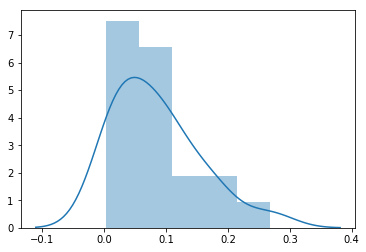

In [364]:
data = np.random.beta(1,9,20)

sns.distplot(data)

In [375]:
bootSamples = [np.mean(np.random.choice(data,len(data))) for _ in range(10000)]

M = np.mean(data)
deltaStar = [x-M for x in bootSamples]
intervals = np.percentile(deltaStar, [2.5,97.5])
print(intervals)
print("M={} 95% CI [{}, {}]".format(round(M, 2), round(M+intervals[0],2), round(M+intervals[1], 2)))

[-0.0281023   0.03149967]
M=0.08 95% CI [0.06, 0.12]


Notice that the CI is not symmetric about the mean

That's because bootstrapping tells us about the data distribution

Whereas the formula uses $\pm$

# Last bit: difference in means

Case 1:
Two samples drawn from the same distribution

Case 2:
Two samples drawn from different distributions

Can we use the bootstrap to contrast these cases?

In [5]:
group1 = np.random.normal(6,3,35)
group2 = np.random.normal(6,3,40) #Doesn't have to be same size!
group3 = np.random.normal(9,3,30) #Doesn't have to be same size!

def compareMeans(groupA,groupB):
    groupAStar = np.random.choice(groupA,len(groupA))
    groupBStar = np.random.choice(groupB,len(groupB))
    diff = np.mean(groupAStar)-np.mean(groupBStar)
    return(diff)

#compare group1,group2 (same distribution)
diff1_2 = np.mean(group1)-np.mean(group2)
bootSample = [compareMeans(group1,group2) for x in range(10000)]
deltaStar = [x-diff1_2 for x in bootSample]
lower,upper = np.percentile(deltaStar,[2.5, 97.5])
print(diff1_2, diff1_2+lower, diff1_2+upper)

#compare group1,group3 (different distribution)
diff1_3 = np.mean(group1)-np.mean(group3)
bootSample = [compareMeans(group1,group3) for x in range(10000)]
deltaStar = [x-diff1_3 for x in bootSample]
lower,upper = np.percentile(deltaStar,[2.5, 97.5])
print(diff1_3, diff1_3+lower, diff1_3+upper)

0.172618278676 -0.995486630951 1.3558313831
-2.07054596498 -3.2741327279 -0.824599847594


# Final Task

You try it!

Either simulate some date, or use some of your own

Go for between-subjects data

Try plot the distributions

Calculate CIs for the difference in means

# Conclusions

The bootstrap is **robust**
- Why?

The bootstrap is **general**
- Why?

The bootstrap is **simple**
- Why?

The bootstrap is **modern**
- Why?


# Next week

- Using the `boot` package (R) to handle all the resampling and confidence intervals for us
- Regression parameters
- Other statistics
- Why care about confidence intervals? "The new statistics"
- Parametric vs. non-parametric bootstrap
- Bootstrap vs. random permutation test
- DIY